## Objective
In this notebook I set up the functions to import and prepare the scans for training. The end goal is to have a function that takes the file addresses as input and returns X and y arrays for training (in sklearn and Keras convention). When development is done, these functions to should be written to a .py file that can be read from the training script.

Data augmentation is going to be done during training to make the process memory efficient. Keras provides an [`ImageDataGenerator`](https://keras.io/preprocessing/image/) class with several augmentation capabilities. For an example, see https://machinelearningmastery.com/image-augmentation-deep-learning-keras/.

#  Notes
* When scaling the whole painting, underlying tilts from the scanning will not go away. That means you can have entire portions of the paiting with data in a certain range, like (1,2] and the other portion at [0,1].
* Due to the point above, I defined a `shift` option in the `get_patches` function to subtract off the mean of each patch.
* *NaNs* should be avoided in the profilometer scanning process. However, if they end up appearing, there is a `dropna` option to discard patches with any *NaN* pixel. That could lead to class imbalance.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# for sampling and processing
from sklearn.feature_extraction.image import extract_patches
from sklearn.preprocessing import StandardScaler, RobustScaler

%matplotlib inline

# Function definitions

## Importing and Adjusting

In [2]:
def data_to_array(data_address):
    """Imports x,y,z txt data, grabs and reshapes z values,
    returns ndarray with appropriate shape.
    
    Parameters
    ----------
    data_address: str
        file of xyz data
    
    Returns
    ----------
    data: 2d ndarray with z values"""
    # import data
    data = pd.read_csv(data_address, header=None,
                  names = ['x','y','z'])
    # find out length and width
    width, length = data['y'].nunique(), data['x'].nunique()
    # get z-data as reshaped ndarray 
    z_arr = data['z'].values.reshape(width, length)
    # set negative values no NaNs
    z_arr[z_arr<0] = None
    return z_arr

In [3]:
def scale_data(data, scaler):
    """Takes data and sklearn scaler as input, returns scaled data.
    The function's purpose is to deal with reshaping."""
    # fit scaler to flattened data
    data_scaled = scaler.fit_transform(np.ravel(data).reshape(-1,1))
    # returns scaled data in original dimensions
    return data_scaled.reshape(data.shape)

## Sampling

In [4]:
def get_patches(data, patch_size, shift=True, dropna=True):
    """Splits the data uniformly in square patches of 
    size patch_size. Returns new array with each patch.
    
    Parameters
    ----------
    data : ndarray
       2d array of which patches are extracted
    patch_size : integer
        The size of the patch square side
    shift: bool
        If True, subtract off mean of each patch
    dropna: bool
        If True, discard patches with any NaN element
        
    Returns
    ----------
    patches: 3d array of dimensions (n_patches, patch_size, patch_size)
    """
    patches = extract_patches(data, patch_size, 
                              extraction_step=patch_size)
    patches = patches.reshape(-1,patch_size,patch_size)
    if dropna:
        # drop patches with nans in them
        patches = patches[~np.isnan(patches).any(axis=(1,2))]
    if shift:
        # take mean of each patch and reshape it for subtaction
        means = np.mean(patches, axis=(1,2)).reshape(-1,1,1)
        patches -= means
    return patches

In [5]:
def get_X_y(data_list):
    """
    Parameters
    ---------
    data_tuple: list of arrays
        A list with arrays of patches
   
    Returns
    ---------
    X, y: X is an array with the patches and y has the corresponding labels as ints
    """
    y_list = [None]*len(data_list)
    
    for i, data in enumerate(data_list):
        y_list[i] = i*np.ones(len(data))

    y = np.concatenate(y_list).reshape(-1,1)
    X = np.concatenate(data_list)
    return X, y

## Pipeline

In [14]:
# create a function that combines all the previous steps

# Function tests

## Import and scale

In [7]:
d = data_to_array('./data/sample_data/Farah_Pot_5cm_sq_15um.txt')
ds = scale_data(d, RobustScaler())

### The scaled patch shold have O(1) amplitudes.

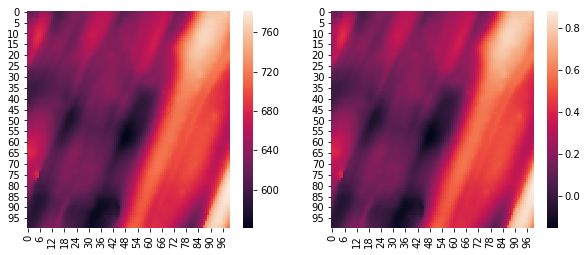

In [8]:
fig, [ax1,ax2] = plt.subplots(1,2,figsize=(10,4))

crop = 100
sns.heatmap(d[:crop,:crop], ax = ax1);
sns.heatmap(ds[:crop,:crop], ax = ax2);

## Sample and shift

### The mean should be approximately zero (up to machine precision).

mean = -2.842170943040401e-17


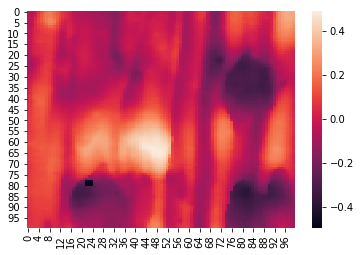

In [9]:
patches = get_patches(ds, 100)
idx = np.random.randint(0,len(patches),1)[0]
sns.heatmap(patches[idx])
print('mean = {}'.format(np.mean(patches[idx])))

### X should have shape (number of patches, patch_size, patch_size)
### y should have shape (number of patches, 1)

In [10]:
fname = './data/sample_data/Farah_Pot_5cm_sq_15um.txt'
d1 = data_to_array(fname)
ds1 = scale_data(d1, RobustScaler())
patches1 = get_patches(ds1, 100)

In [11]:
fname = './data/sample_data/Grant_Pot_5cm_sq_15um.txt'
d2 = data_to_array(fname)
ds2 = scale_data(d2, RobustScaler())
patches2 = get_patches(ds2, 100)

In [12]:
X, y = get_X_y([patches1,patches2])

In [13]:
print(X.shape,y.shape)

(2064, 100, 100) (2064, 1)
